In [1]:
import pandas as pd
import gzip
import ast
import re,os
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata
import seaborn as sns
import json, re
import collections
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from data_prep import DataPrep
from sklearn.feature_extraction.text import TfidfVectorizer
from math import pi

import pickle
model= pickle.load(open('akurasi95%.sav','rb'))    

In [2]:
class Model():
    def __init__(self):
        self.rfr = RandomForestRegressor(bootstrap=True,
         max_features='sqrt',
         min_samples_leaf=1,
         min_samples_split=2,
         n_estimators= 200)
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)
        if regression:
            self.rfr = self.rfr.fit(X, y)
        else:
            self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)
        if regression:
            return self.rfr.predict(X)
        else:
            return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)
        if regression:
            raise ValueError('Cannot predict probabilites of a regression!')
        else:
            return self.rfc.predict_proba(X)

In [3]:
def predict_model(model_,model_personality,data_test):
    for index, model in enumerate(model_):
        x=model_personality[index].predict_proba(data_test['message'], regression=False)
        data_test[model]=[i[1]*100 for i in list(x)]
    return data_test

In [4]:
def posting_account(path):
    if path[-1]!="\\":
        path=path+"\\"
    for i in os.listdir(path):
        if 'info' in i:
            file_info=i
        if 'posts' in i:
            file_post=i

    with open(path+file_info) as json_file:  
        info_account = json.load(json_file)

    page_account=[]
    group_account=[]
    user_id=info_account['user_id']
    for i in info_account['likes']:
        page_account.append({'user_id':user_id,'page_id':i['page_id'],'page_name':i['page_name']})
    for i in info_account['groups']:
        group_account.append({'user_id':user_id,'group_id':i['group_id'],'group_name':i['group_name']})

    page=pd.DataFrame(page_account)
    group=pd.DataFrame(group_account)
    post_account = []
    with open(path+file_post) as f:
        for line in f:
            post_account.append(json.loads(line))
    #     print("total post :",len(post_account))
    post=[]
    for i in post_account:
        post.append({'account_id':i['user_id'],'message':i['text']})
        username=i['user_full_name']

    df_post=pd.DataFrame(post).dropna().reset_index()
    try:
        df_post=predict_model(model_,model_personality,df_post)
    except:
        print('gagal')
    return df_post, user_id,username, page_account, group_account

# ACCOUNT by post

In [5]:
def big5_personality(ops1,ops2,score):
    if score>50:
        a=ops2
    else :
        a=ops1
    return a
def result_by_post(df_post):
    AGR=df_post['AGR'].mean()
    CON=df_post['CON'].mean()
    EXT=df_post['EXT'].mean()
    NEU=df_post['NEU'].mean()
    OPN=df_post['OPN'].mean()   
    opn=big5_personality('Conservative and Traditional','Liberal and Artistic',OPN)
    con=big5_personality('Impulsive and Spontaneous','Organized and Hard Working',CON)
    ext=big5_personality('Contemplative','Engaged with outside world', EXT)
    agr=big5_personality('Competitive','Team working and Trusting',AGR)
    neu=big5_personality('Laid back and Relaxed','Easily Stressed and Emotional',NEU)
    return opn,con,ext,agr,neu
    


# Tendency by page name and group name

# visualisation

In [45]:
def spider(df_result, title, user_id,username,path):
    col=['AGR','CON','EXT','NEU','OPN']
    categories=list(df_result)[:5]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=df_result[col].values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='blue', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    ylim=sorted(values, reverse=True)[0]
    plt.yticks([ylim/10,ylim/2,ylim], [str(int(ylim/10)),str(int(ylim/2)),str(int(ylim))], color="blue", size=7)
    plt.ylim(0,ylim+10)
    plt.title(title, size=15,  y=1.1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig(f"{path}/{title}_{user_id}_{username}.png")
    plt.show()
    
def define_persen(kanan):
    kanan=int(kanan)
    if 100-kanan>=0:
        kiri=100-kanan
    else:
        kiri=kanan
        kanan= 100-kiri
    return kiri,kanan

def tornado(df_result, titles, user_id,username,path):
    col=['AGR','CON','EXT','NEU','OPN']
    kiri_label=['Conservative and Traditional',
                'Impulsive and Spontaneous','Contemplative',
                'Competitive','Laid back and Relaxed'][::-1]

    kanan_label=['Liberal and Artistic','Organized and Hard Working',
                 'Engaged with outside world','Team working and Trusting',
                 'Easily Stressed and Emotional'][::-1]
    
    kiri=[]
    kanan=[]
    for index,i in enumerate(df_result[col].values[0]):
        x=define_persen(i)
        kiri.append(x[0])
        kanan.append(x[1])

    y=range(5)
    fig, axes = plt.subplots(ncols=2, sharey=True)
    axes[0].barh(y, kiri, align='center', color='red')
    axes[1].barh(y, kanan, align='center', color='blue')

    for i, (p, pr) in enumerate(zip(kiri_label, kiri)):

        axes[0].text(s=p, x=pr+5, y=i, color="blue", verticalalignment="center", horizontalalignment="right",size=10)

        axes[0].text(s=str(pr)+"%", x=16, y=i, color="w",
                 verticalalignment="center", horizontalalignment="left", size=12)

    for i, (p, pr) in enumerate(zip(kanan_label, kanan)):
        axes[1].text(s=p, x=pr+5, y=i, color="red", verticalalignment="center", horizontalalignment="left", size=10)

        axes[1].text(s=str(pr)+"%", x=2, y=i, color="w",
                 verticalalignment="center", horizontalalignment="left", size=12)

    axes[0].axis("off")
    axes[1].axis("off")
    axes[0].invert_xaxis()
    plt.title(titles+'\n', size=12,x=0,horizontalalignment="center")
    plt.savefig(f"{path}/{titles}_{user_id}_{username}.png")
    plt.show()

# model

In [9]:
model_personality=[None]*5
path="E:\\belajar\\personality-prediction-from-text-master\\static\\"
list_model=[]
model_=[]
for i in os.listdir(path):
    if '.pkl' in i:
        list_model.append(path+i)
        model_.append(i.replace('_model.pkl',''))
        
M=Model()
for i in range(5):
    with open(list_model[i], 'rb') as f:
        model_personality[i]= pickle.load(f)
        
 

In [10]:
list_file=[]
for i in os.listdir("E:\\belajar\\Psycopath\\"):
    try:
        int(i.split('_')[-1])
        list_file.append("E:\\belajar\\Psycopath\\"+i)
    except:
        pass

In [50]:
def result_overall(path_file):
    df_post,user_id,username,page_account,group_account=posting_account(path_file)
    col=['AGR','CON','EXT','NEU','OPN']
    page_acc=pd.DataFrame(page_account)
    group_acc=pd.DataFrame(group_account)
    page_=page_acc['page_name'].sum()
    group_ =group_acc['group_name'].sum()  
    tendency_group=model.predict([group_])[0]
    tendency_page=model.predict([page_])[0]

    index=0

    acc_id=user_id
    username=username
    df_acc=df_post

    if len(df_acc)==0:
        df_acc.loc[len(df_acc),tuple(col)]=0

    AGR=df_acc['AGR'].mean()
    CON=df_acc['CON'].mean()
    EXT=df_acc['EXT'].mean()
    NEU=df_acc['NEU'].mean() 
    OPN=df_acc['OPN'].mean()

    df_result=pd.DataFrame([{'account_id':acc_id,'username':username,'AGR':AGR, 'CON':CON, 'EXT':EXT,
                      'NEU':NEU,'OPN':OPN,'tendency by groups':tendency_group,'tendency by pages':tendency_page}])
    tornado(df_result,'Personality Description',user_id,username,path_file)
    spider(df_result,'Big 5',user_id,username,path_file)
    df_result.to_csv(f'{path_file}/Personality_{username}_{user_id}.csv')
    return df_result

C:\Users\eBdesk\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


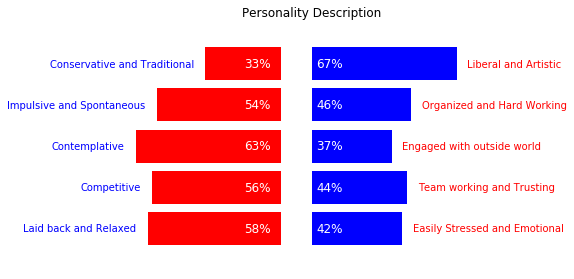

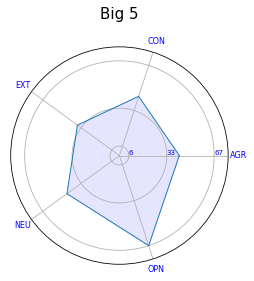

,AGR,CON,EXT,NEU,OPN,account_id,tendency by groups,tendency by pages,username
0,42.850351,44.565253,37.112202,46.413979,67.788232,100001711422548,prabowo,prabowo,Aisyah Binti Abdullah


In [51]:
result_overall(list_file[0])

In [4]:
from OCEAN import model as modol
from OCEAN import preprocessor


Using TensorFlow backend.


In [29]:
msg=preprocessor.preprocess(  ["selamat datang",'welcome to the rumah','read bone']  )
result=modol.predict(   [msg]   )

In [49]:
import time
report = {
    'data': x,
    'status': True,
    'timestamp': int(time.time()*1000)
}

In [70]:
    x={'OPN':result['OPN'].mean(),'CON':result['CON'].mean(),
       'EXT':result['EXT'].mean(),'AGR':result['AGR'].mean(),
       'NEU':result['NEU'].mean()}

In [69]:
import pandas as pd
result['CON'].mean(axis=1)

array([0.43323445, 0.4391827 , 0.17094535], dtype=float32)

In [74]:
type(x['OPN'])

numpy.float32

In [76]:
type(float(x['OPN']))

float

In [43]:
for i in c:
    print(i[0])
opn=

0.705597996711731
0.6711646318435669
0.7659791111946106


In [81]:
import requests
x={"text":["selamat datang LOLIII","wonderfull","selamat tahunbaru","hari senin"]}

url = 'http://192.168.99.105:2121/ocean_predict'
resp = requests.post(url=url, json=x)
data = resp.json()

In [82]:
data

{'data': {'AGR': 0.6084310412406921,
  'CON': 0.43118801712989807,
  'EXT': 0.40412309765815735,
  'NEU': 0.3201684057712555,
  'OPN': 0.7223601937294006},
 'status': True,
 'timestamp': 1551326956115}